In [17]:
import os
import sys
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, roc_curve

In [18]:
root = "./stanford-dogs-dataset/images/Images/"
annroot = "./stanford-dogs-dataset/annotations/Annotation/"
thumbroot = "./thumbnails/"

In [19]:
## Helper Functions

def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def getAnnotations(ann_path):
    tree = ET.parse(ann_path)
    root = tree.getroot()
    xmin = int(root.find("object/bndbox/xmin").text)
    ymin = int(root.find("object/bndbox/ymin").text)
    xmax = int(root.find("object/bndbox/xmax").text)
    ymax = int(root.find("object/bndbox/ymax").text)
    return (xmin, ymin, xmax, ymax)

def getAnnpath(img_path):
    ann_path = img_path.replace("images", "annotations").replace("Images", "Annotation")
    ann_path = os.path.splitext(ann_path)[0]
    return ann_path

In [20]:
## Generate Label Dictionary (id, label)

dictionary={}
subdirs = os.listdir(root)
for dir in subdirs:
    key = dir.split("-", 1)[0]
    value = dir.split("-", 1)[1]
    dictionary[key] = value

In [21]:
## Original Data Size
print("Calculating original data size ...")

count = 0
heights = []
widths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
        count += 1
        sys.stdout.write("Progress calculating: {:.2%}\r".format(count/20580))
        sys.stdout.flush()

min_height = min(heights)
min_width = min(widths)
total = count

Calculating original data size ...


In [22]:
print("Number of image: ", total)
print("Min image height: ", min_height)
print("Min image width: ", min_width)

Number of image:  20580
Min image height:  100
Min image width:  97


In [23]:
## Cropped Image Size
print("Calculating cropped image size ...")

count = 0
cropped_heights = []
cropped_widths = []
for path, subdirs, files in os.walk(annroot):
    for name in files:
        ann_path = os.path.join(path, name)
        xmin, ymin, xmax, ymax = getAnnotations(ann_path)
        cropped_widths.append(xmax-xmin)
        cropped_heights.append(ymax-ymin)
        
        count += 1
        sys.stdout.write("Progress calculating: {:.2%}\r".format(count/20580))
        sys.stdout.flush()

min_cropped_height = min(cropped_heights)
min_cropped_width = min(cropped_widths)

max_cropped_height = max(cropped_heights)
max_cropped_width = max(cropped_widths)

Calculating cropped image size ...


In [24]:
print("Min cropped height: ", min_cropped_height)
print("Min cropped width: ", min_cropped_width)
print("Max cropped height: ", max_cropped_height)
print("Max cropped width: ", max_cropped_width)

Min cropped height:  38
Min cropped width:  32
Max cropped height:  2025
Max cropped width:  2735


In [25]:
resize_W, resize_H = 100, 100
components = 1500

In [26]:
## Generate cropped, same-sized, grey-scaled images in another file
print("Generating cropped, same-sized, grey-scaled images ...")

# Check if old files exists
files = os.listdir(thumbroot)
if files:
    for f in files:
        os.unlink(os.path.join(thumbroot, f))
    
# Start generating 
count = 0
for path, subdirs, files in os.walk(root):
    for name in files:
        img_path = os.path.join(path, name)
        thumb_path = os.path.join(thumbroot, name)
        ann_path = getAnnpath(img_path)
        
        img = Image.open(img_path)
        cr_img = img.crop(getAnnotations(ann_path))
        re_img = cr_img.resize((resize_W, resize_H), Image.ANTIALIAS)
        gr_img = re_img.convert("L")
        gr_img.save(thumb_path, quality=95)

        count += 1
        writeProgress("Progress generating images: ", count, total)

Generating cropped, same-sized, grey-scaled images ...


In [27]:
## Read Images to ndarray
print("Reading images ...")

images = []
labels = []
count = 0

for name in os.listdir(thumbroot):
    img_path = os.path.join(thumbroot, name)
    img = mpimg.imread(img_path)
    images.append(img)

    key = name.split("_", 1)[0]
    label = dictionary[key]
    labels.append(label)

    count += 1
    writeProgress("Progress loading images: ", count, total)

X = np.array(images)
Y = np.array(labels)

Reading images ...


In [28]:
## Data Size (after resizing)
print("X shape: ", X.shape)
print("Y size: ", Y.size)

X shape:  (20580, 100, 100)
Y size:  20580


(100, 100)


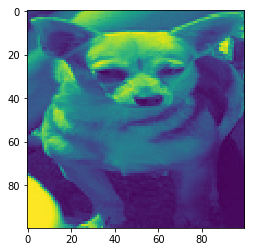

In [29]:
plt.imshow(X[0])
print(X[0].shape)

In [30]:
## Flaten Image List (bcuz NMF only consumes 2D data)

X_flat = np.array(X).reshape((X.shape[0], X.shape[1]*X.shape[2]))

In [31]:
## Split Test / Train
print("Spliting Test / Train sets ...")

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

Spliting Test / Train sets ...


In [32]:
## Data Size (after spliting)
print("X train shape: ", X_train.shape)
print("Y train size: ", y_train.size)
print("X test shape: ", X_test.shape)
print("Y test size: ", y_test.size)

X train shape:  (14406, 10000)
Y train size:  14406
X test shape:  (6174, 10000)
Y test size:  6174


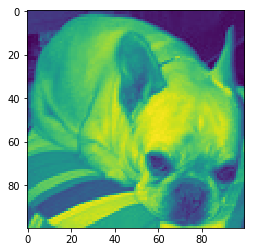

In [33]:
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

In [34]:
## PCA
print("PCA ...")

pca = PCA(n_components=components)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

PCA ...


In [35]:
## Data Size
print("Reduced Shape: " + str(X_reduced.shape))
print("Recovered Shape: " + str(X_recovered.shape))

Reduced Shape: (14406, 1500)
Recovered Shape: (14406, 10000)


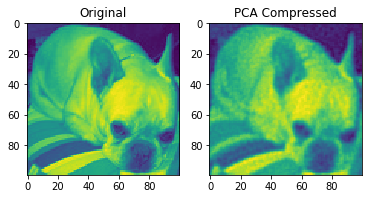

In [36]:
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

f.add_subplot(1,2, 2)
plt.title("PCA Compressed")
plt.imshow(X_recovered[0].reshape(X.shape[1], X.shape[2]))

plt.show(block=True)

In [37]:
## Classification - MLP (reduced)
print("Classifying reduced images ...")

# Training
print("Training ...")

mlp_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1, verbose=True)
mlp_reduced.fit(X_reduced, y_train)

Classifying reduced images ...
Training ...
Iteration 1, loss = 17.54804834
Iteration 2, loss = 6.64656007
Iteration 3, loss = 4.96429887
Iteration 4, loss = 4.76960741
Iteration 5, loss = 4.70448320
Iteration 6, loss = 4.65207646
Iteration 7, loss = 4.61588312
Iteration 8, loss = 4.58279144
Iteration 9, loss = 4.55653633
Iteration 10, loss = 4.54762937
Iteration 11, loss = 4.51255018
Iteration 12, loss = 4.49243603
Iteration 13, loss = 4.50635497
Iteration 14, loss = 4.46164403
Iteration 15, loss = 4.43184566
Iteration 16, loss = 4.44323746
Iteration 17, loss = 4.39872575
Iteration 18, loss = 4.40548333
Iteration 19, loss = 4.37170662
Iteration 20, loss = 4.34174831
Iteration 21, loss = 4.32822736
Iteration 22, loss = 4.32632153
Iteration 23, loss = 4.38306490
Iteration 24, loss = 4.32242672
Iteration 25, loss = 4.31356697
Iteration 26, loss = 4.25738263
Iteration 27, loss = 4.21689863
Iteration 28, loss = 4.22681672
Iteration 29, loss = 4.20173854
Iteration 30, loss = 4.18651528
Iter

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [38]:
# Testing
print("Testing ...")

X_test_reduced = pca.transform(X_test)
y_hat_reduced = mlp_reduced.predict(X_test_reduced)

Testing ...


In [39]:
y_score = mlp_reduced.predict_proba(X_test_reduced).transpose()
mlp_reduced_classes = mlp_reduced.classes_

In [40]:
## Evaluations of reduced images
print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))
print("precision: " + str(precision_score(y_test, y_hat_reduced, average=None)))
print("recall: " + str(recall_score(y_test, y_hat_reduced, average=None)))
print("F1: " + str(f1_score(y_test, y_hat_reduced, average=None)))

accuracy: 0.011661807580174927
precision: [0.00649351 0.         0.01098901 0.         0.         0.07692308
 0.         0.01762115 0.04       0.         0.         0.
 0.         0.         0.13333333 0.         0.         0.
 0.04761905 0.         0.         0.         0.         0.
 0.         0.         0.02702703 0.         0.01315789 0.
 0.         0.14285714 0.         0.         0.         0.
 0.         0.02222222 0.01298701 0.         0.         0.
 0.06451613 0.         0.01388889 0.         0.01052632 0.
 0.         0.         0.         0.25       0.02857143 0.00684932
 0.         0.         0.         0.         0.02352941 0.
 0.03448276 0.06976744 0.         0.00943396 0.01724138 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.05084746
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06666667 0.         0.         0.
 0.         0.         0.0625     0.         0.  

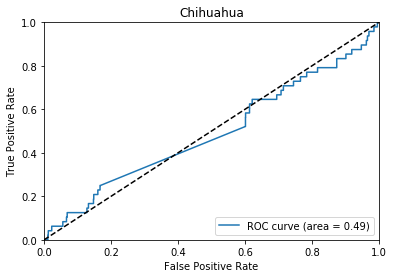

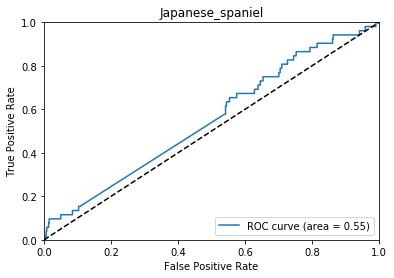

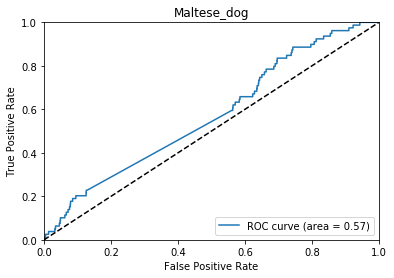

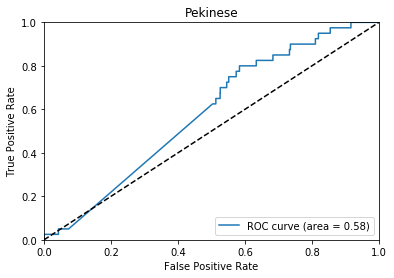

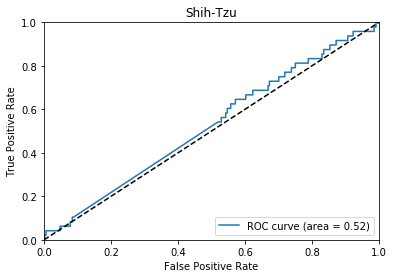

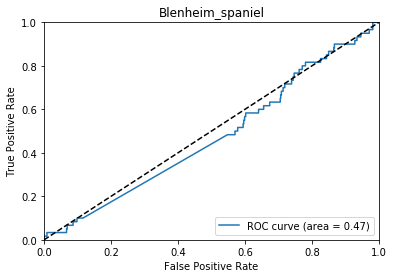

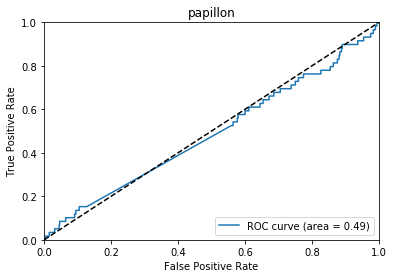

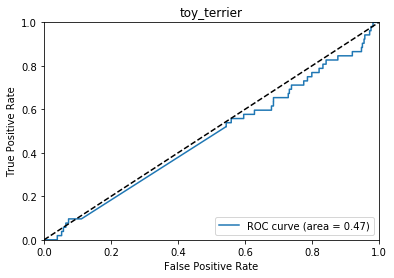

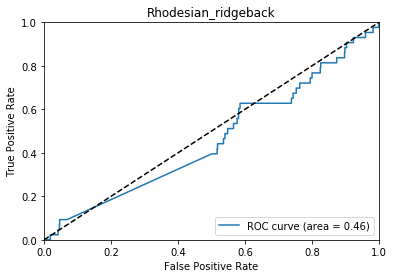

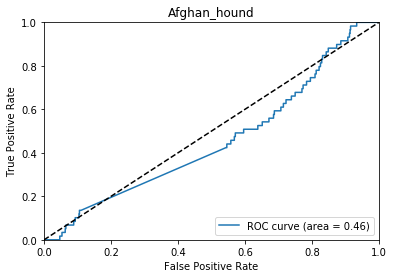

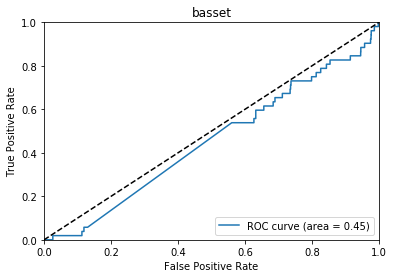

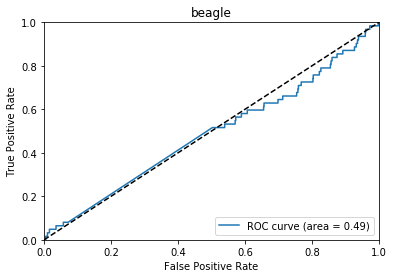

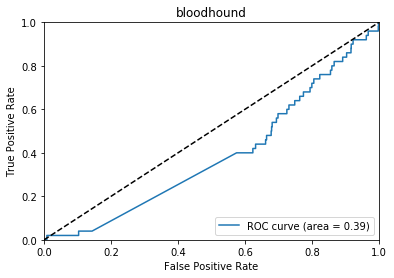

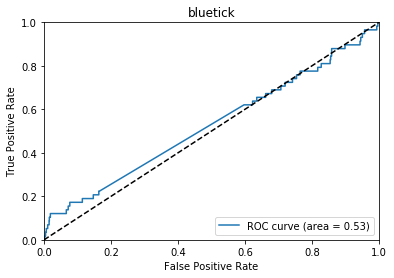

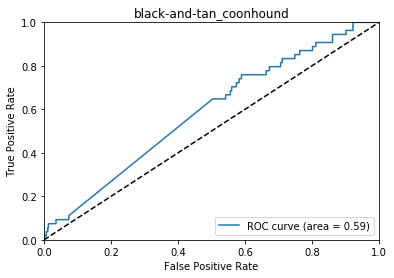

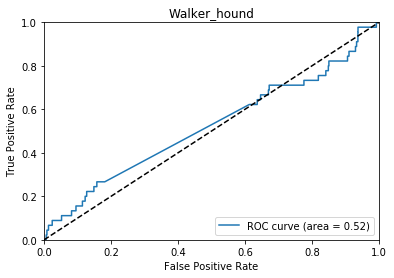

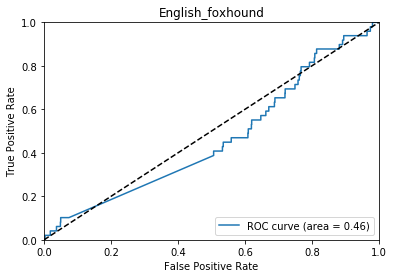

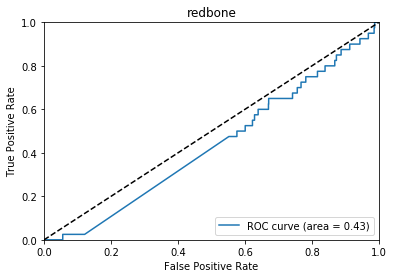

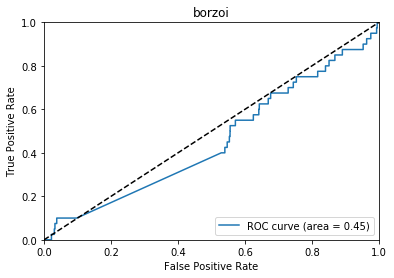

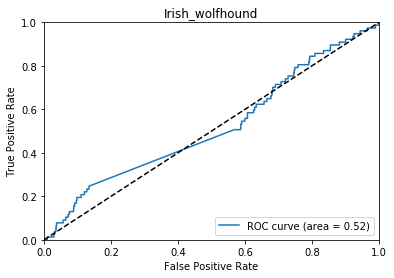

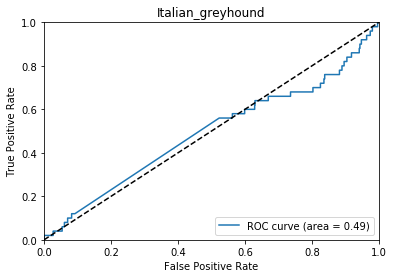

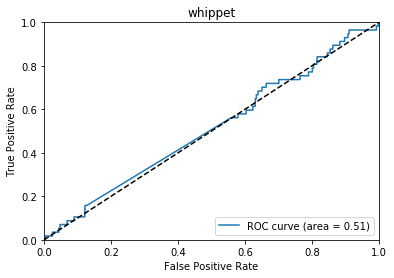

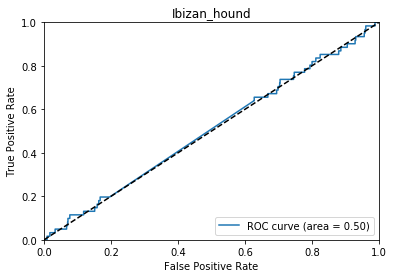

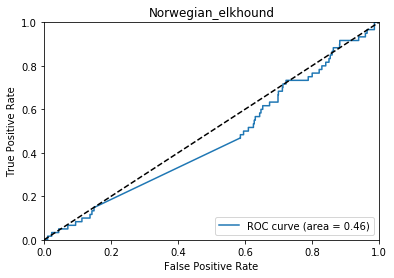

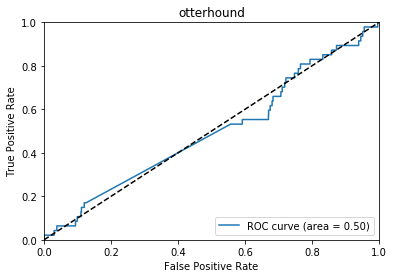

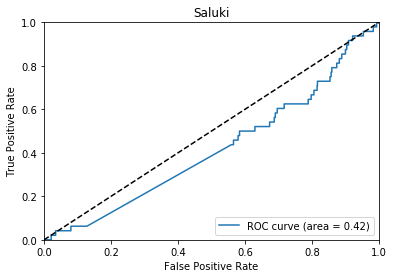

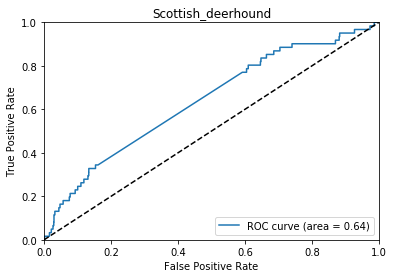

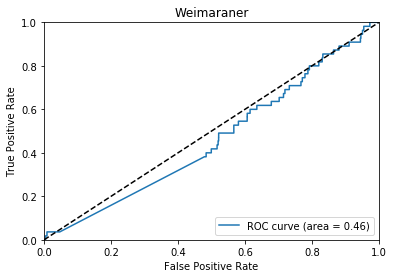

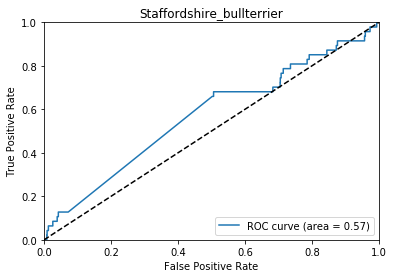

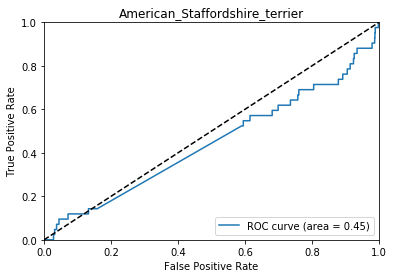

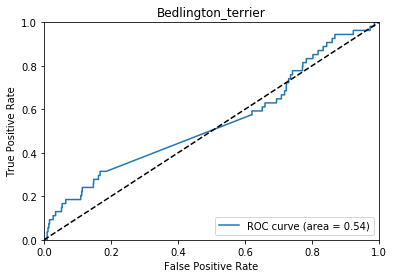

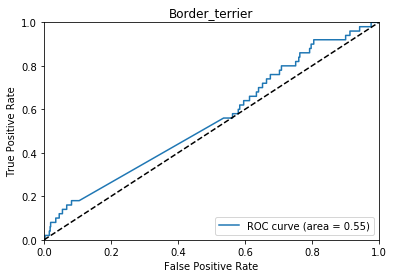

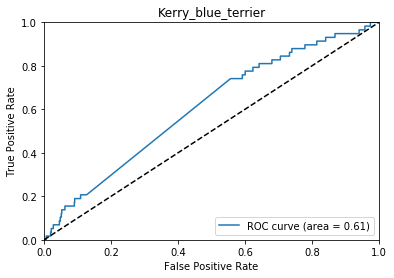

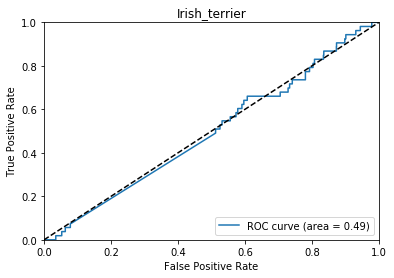

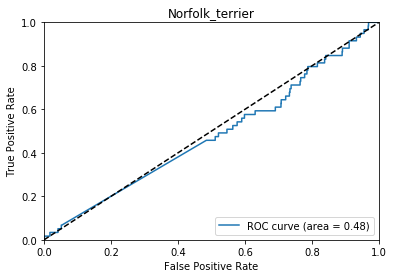

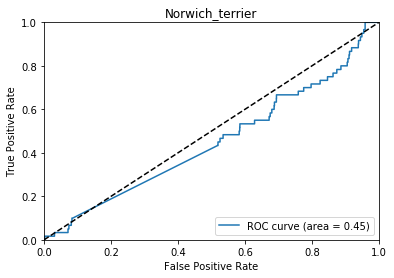

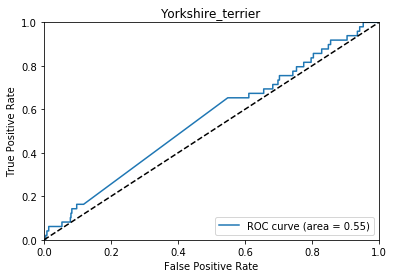

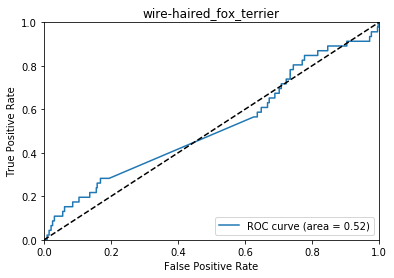

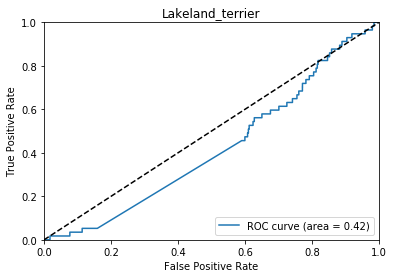

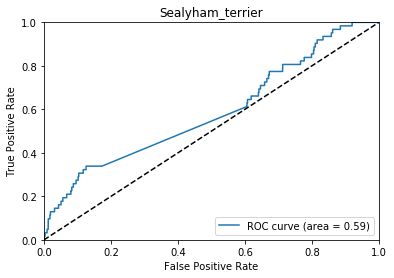

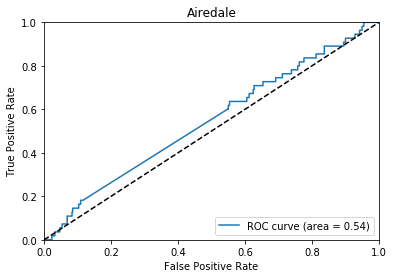

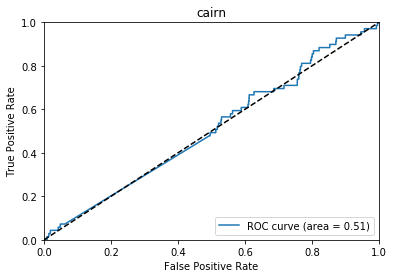

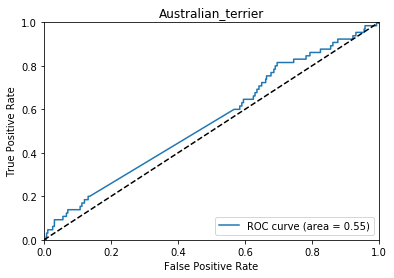

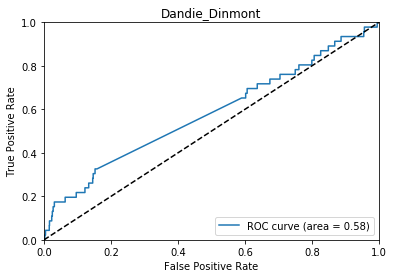

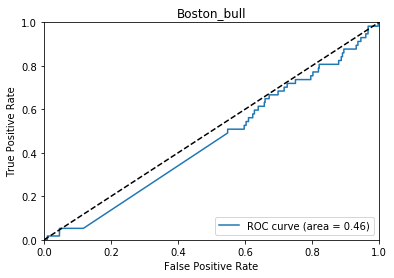

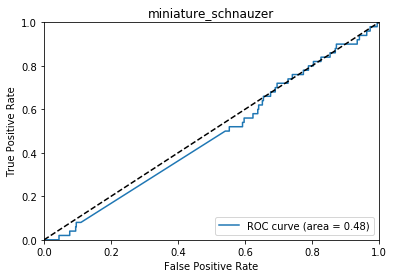

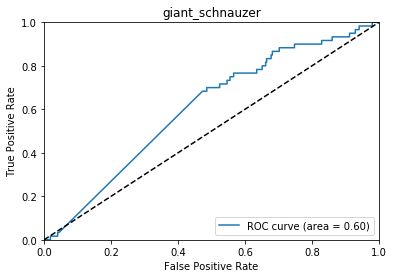

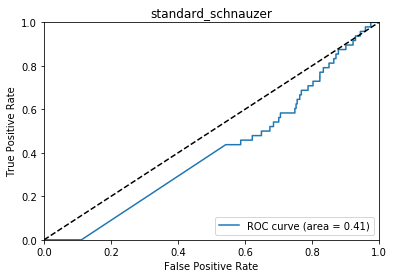

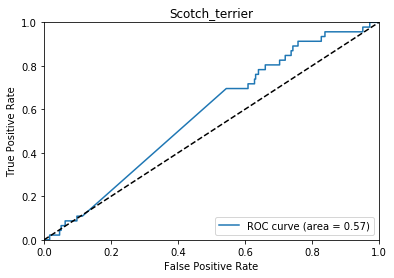

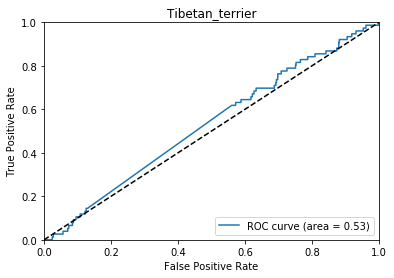

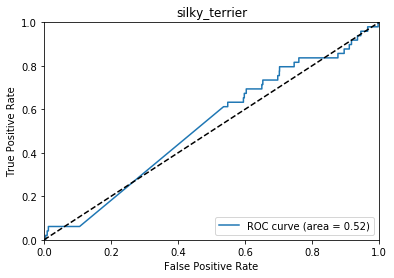

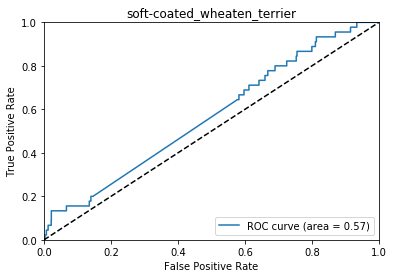

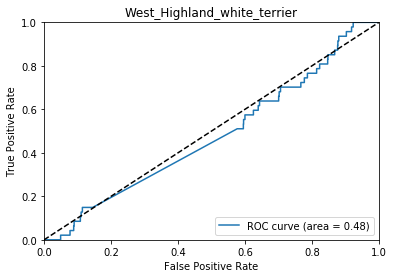

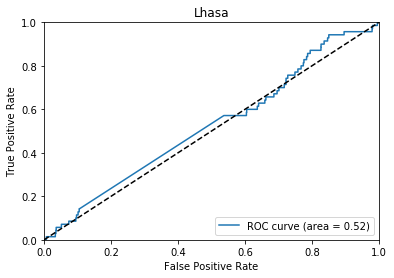

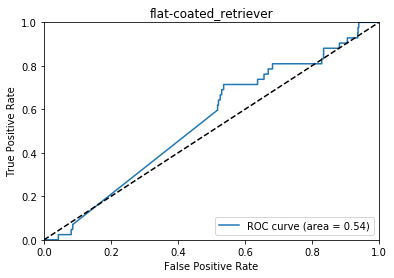

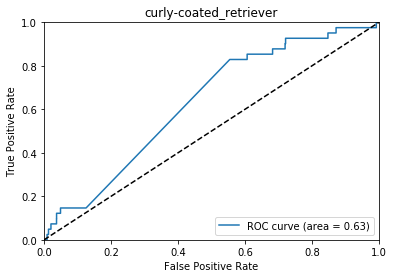

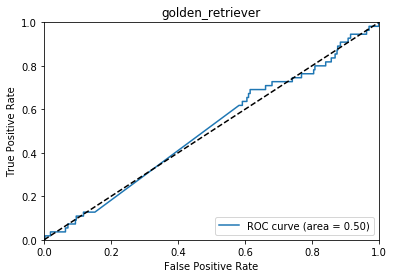

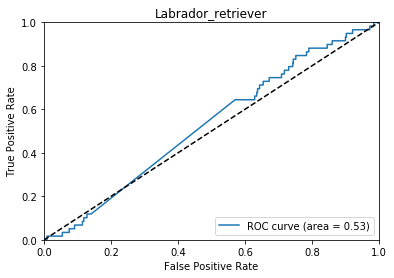

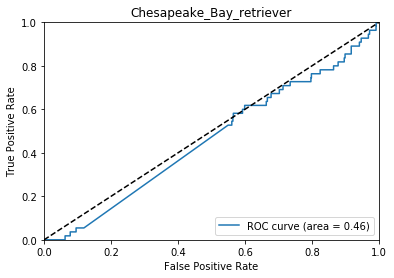

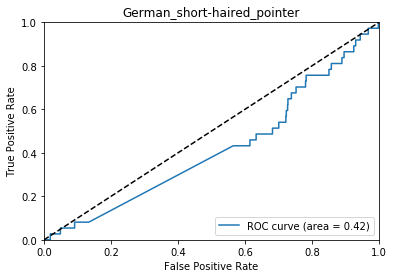

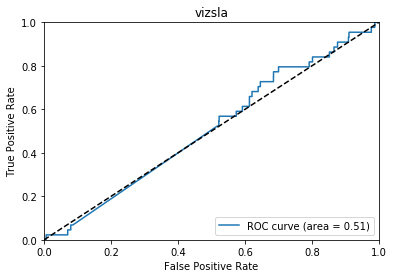

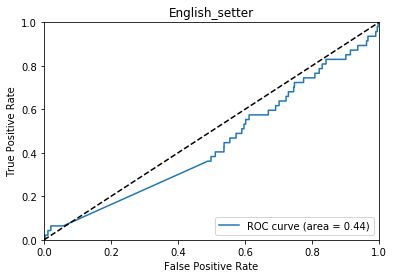

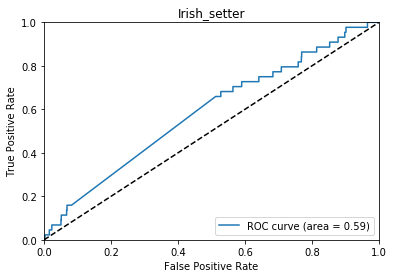

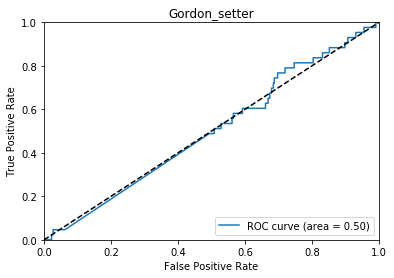

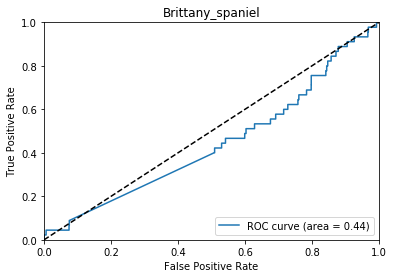

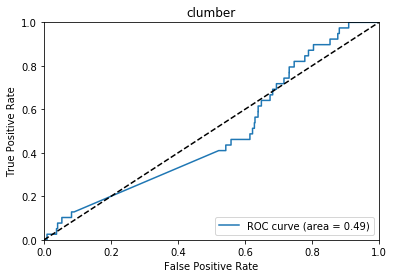

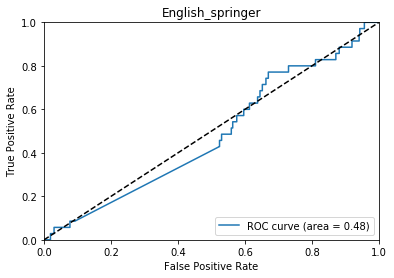

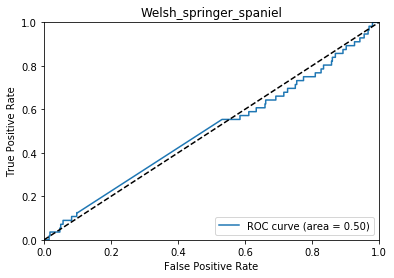

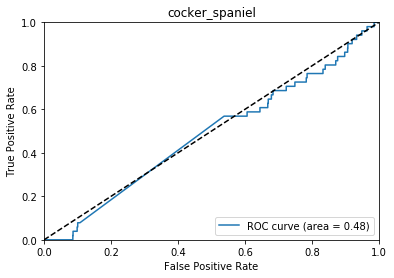

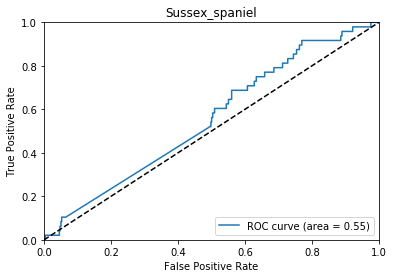

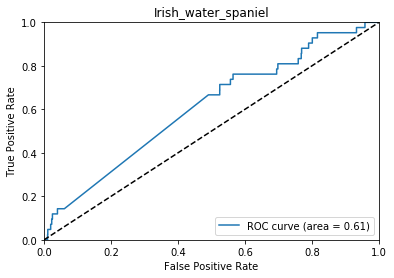

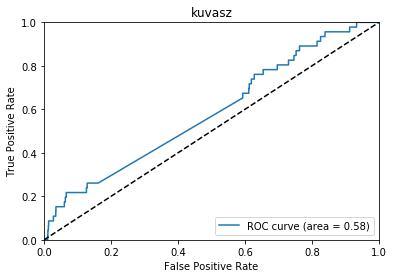

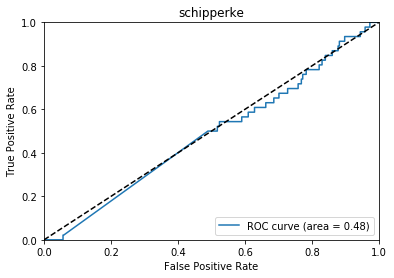

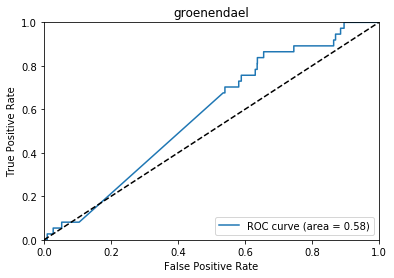

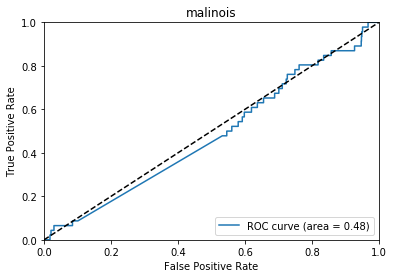

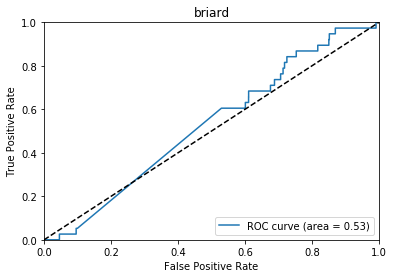

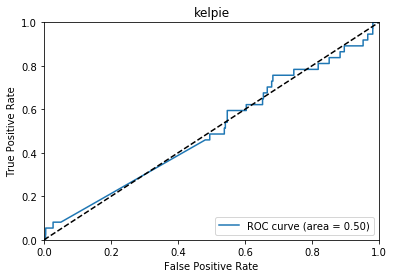

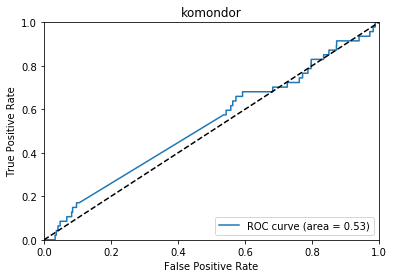

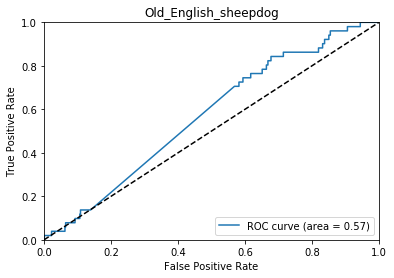

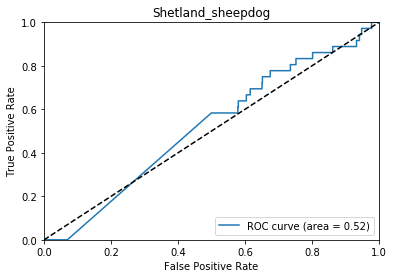

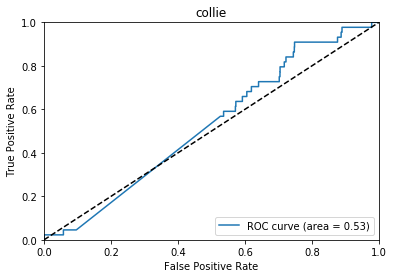

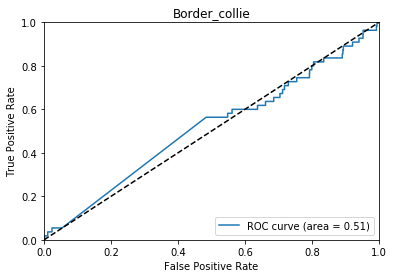

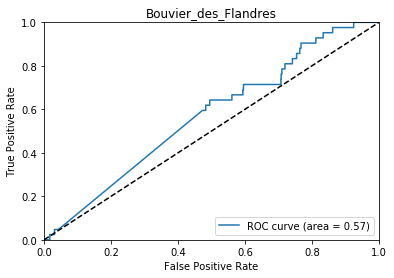

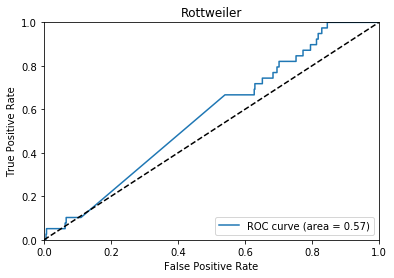

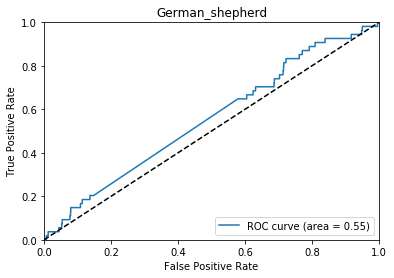

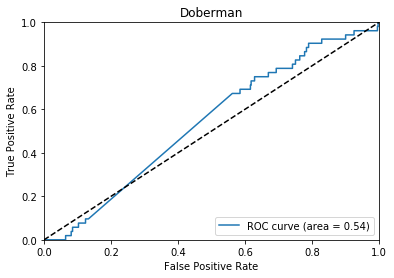

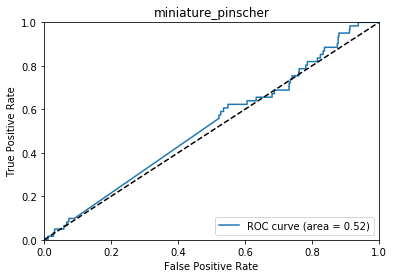

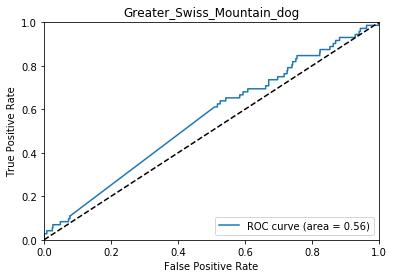

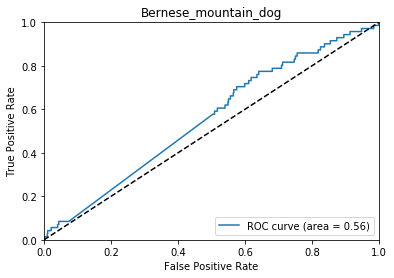

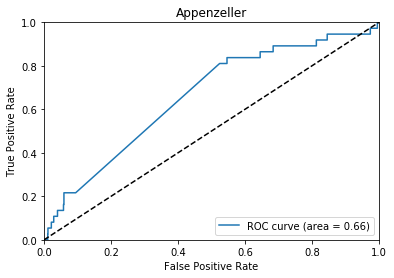

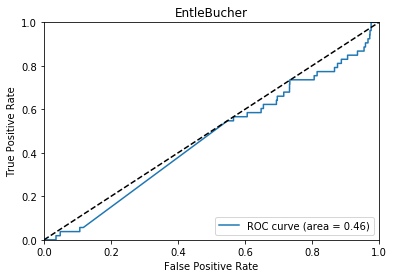

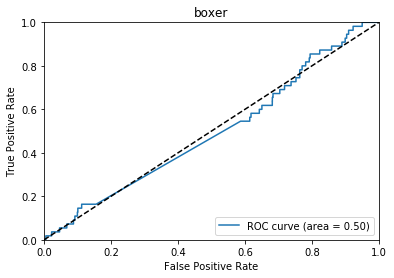

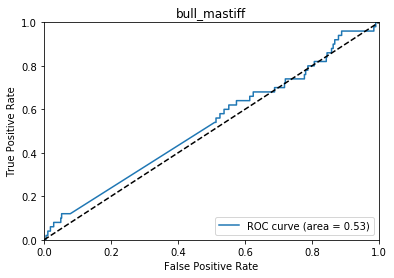

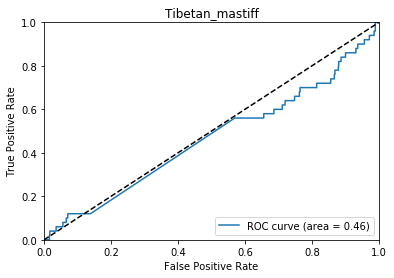

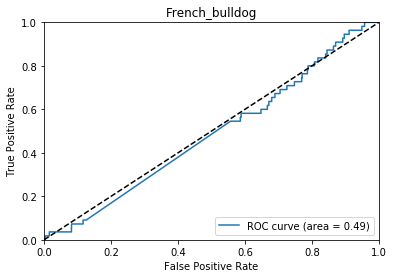

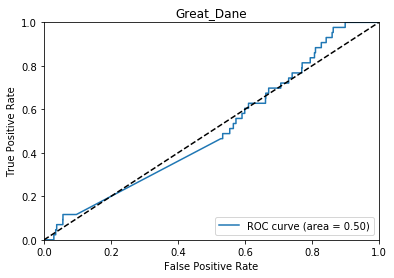

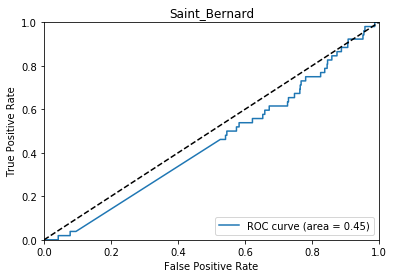

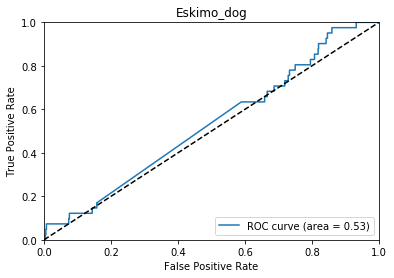

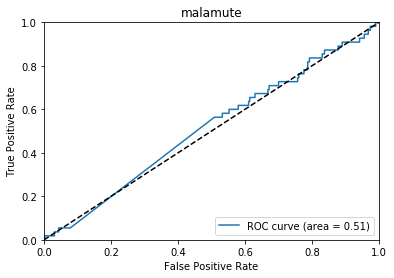

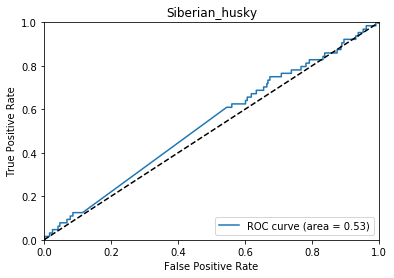

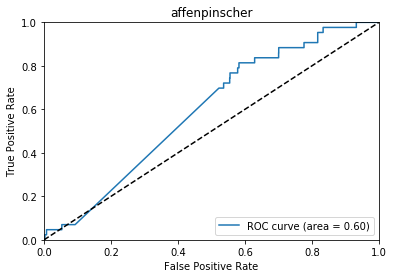

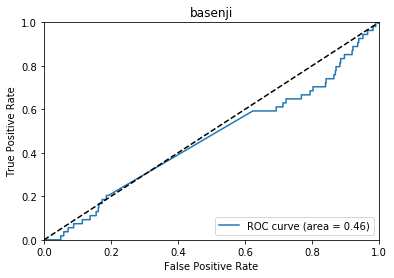

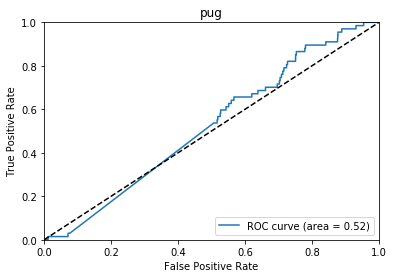

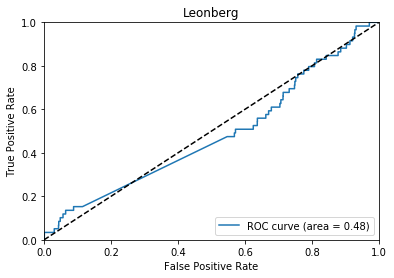

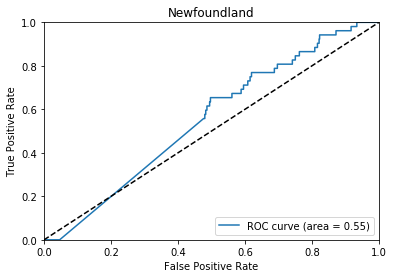

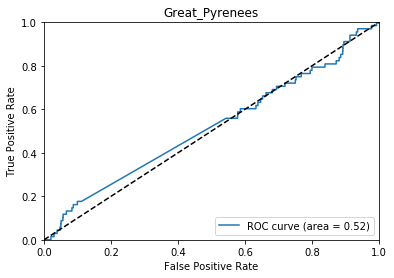

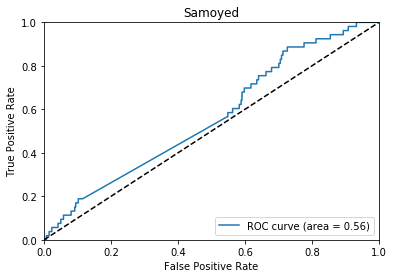

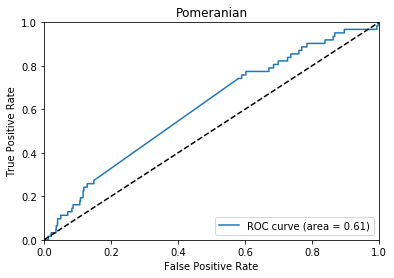

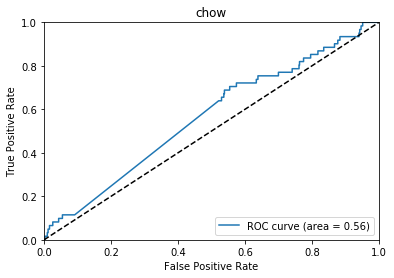

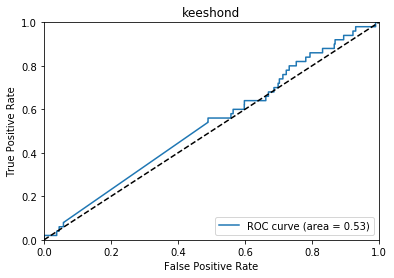

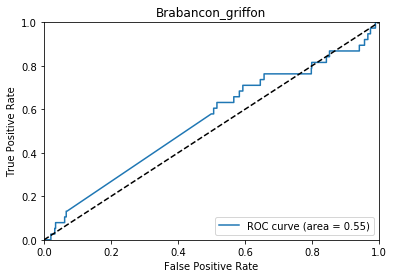

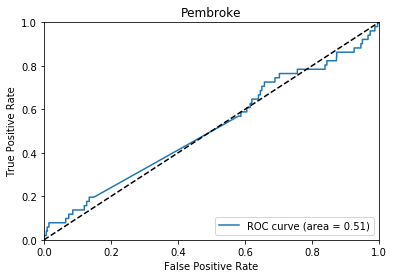

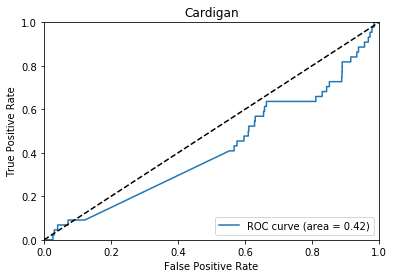

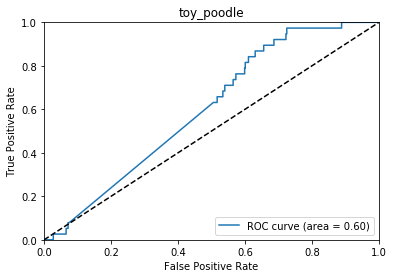

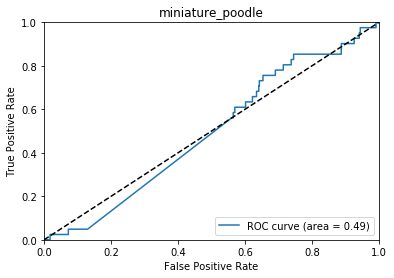

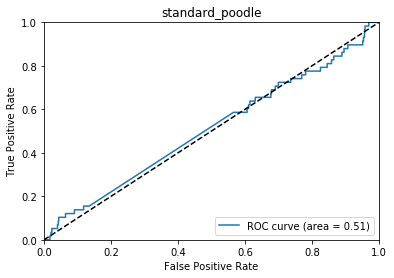

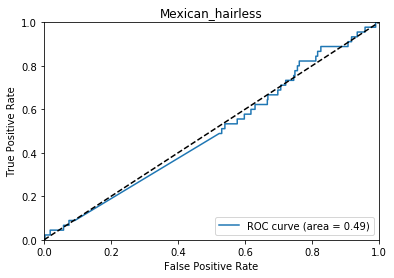

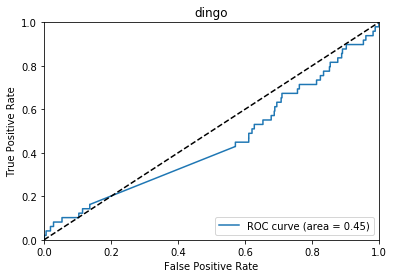

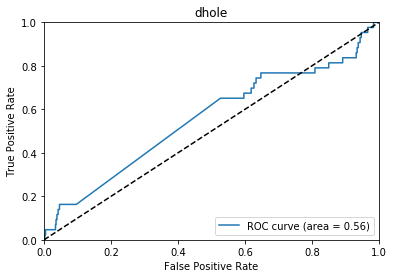

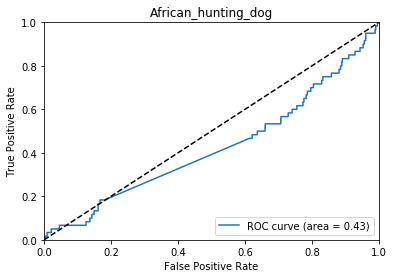

In [41]:
# ROC Curve of reduced images
plt.figure()
for (i, value) in enumerate(dictionary.values()):
    y_score_index = np.where(mlp_reduced_classes==value)[0][0]
    fpr, tpr, _ = roc_curve(y_test, y_score[y_score_index], pos_label=value)
    roc_auc = auc(fpr, tpr)

    # Plot of a ROC curve for a specific class
    f.add_subplot(60, 2, i+1)
    plt.title(value)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [42]:
## Classification - MLP (original)
print("Classifying original images ...")

# Training
print("Training ...")

mlp_orgn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1, verbose=True)
mlp_orgn.fit(X_train, y_train)

Classifying original images ...
Training ...
Iteration 1, loss = 6.32249687
Iteration 2, loss = 4.79009486
Iteration 3, loss = 4.78745495
Iteration 4, loss = 4.78534716
Iteration 5, loss = 4.78356136
Iteration 6, loss = 4.78221776
Iteration 7, loss = 4.78125996
Iteration 8, loss = 4.78045411
Iteration 9, loss = 4.77975707
Iteration 10, loss = 4.77932306
Iteration 11, loss = 4.77895034
Iteration 12, loss = 4.77870300
Iteration 13, loss = 4.77841817
Iteration 14, loss = 4.77832446
Iteration 15, loss = 4.77821211
Iteration 16, loss = 4.77809906
Iteration 17, loss = 4.77799480
Iteration 18, loss = 4.77795989
Iteration 19, loss = 4.77791231
Iteration 20, loss = 4.77784863
Iteration 21, loss = 4.77787207
Iteration 22, loss = 4.77780675
Iteration 23, loss = 4.77781842
Iteration 24, loss = 4.77778796
Iteration 25, loss = 4.77775891
Iteration 26, loss = 4.77775923
Iteration 27, loss = 4.77772926
Iteration 28, loss = 4.77771620
Training loss did not improve more than tol=0.000100 for 10 consecut

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [43]:
# Testing
print("Testing ...")

y_hat_orgn = mlp_orgn.predict(X_test)

Testing ...


In [44]:
y_score = mlp_orgn.predict_proba(X_test).transpose()
mlp_orgn_classes = mlp_orgn.classes_

In [45]:
## Evaluations of original images
print("accuracy: " + str(accuracy_score(y_test, y_hat_orgn)))
print("precision: " + str(precision_score(y_test, y_hat_orgn, average=None)))
print("recall: " + str(recall_score(y_test, y_hat_orgn, average=None)))
print("F1: " + str(f1_score(y_test, y_hat_orgn, average=None)))

accuracy: 0.009556203433754453
precision: [0.0095562 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0

c:\users\vicky lin\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\vicky lin\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


c:\users\vicky lin\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


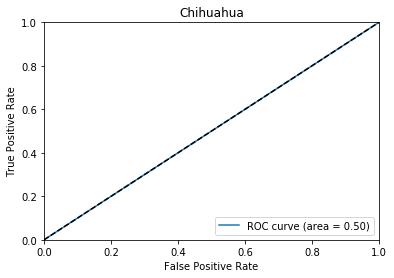

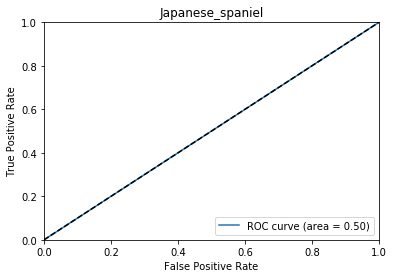

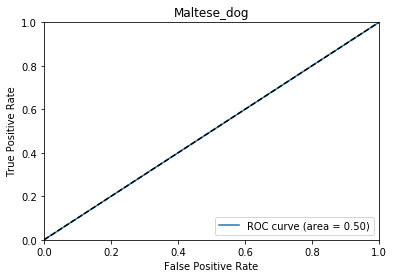

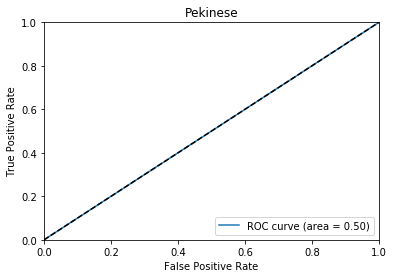

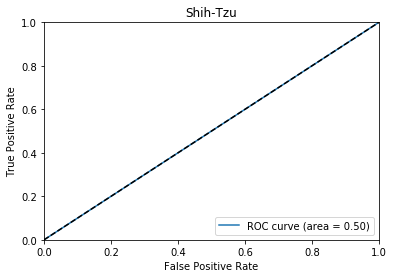

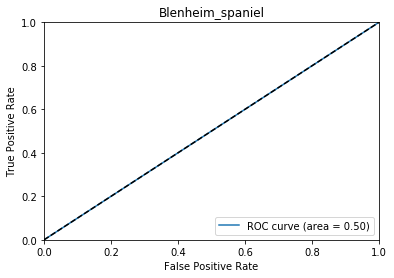

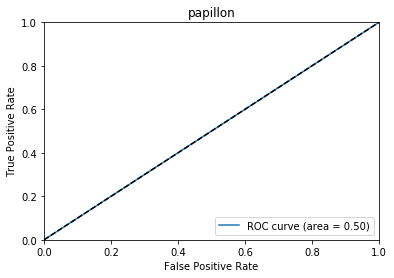

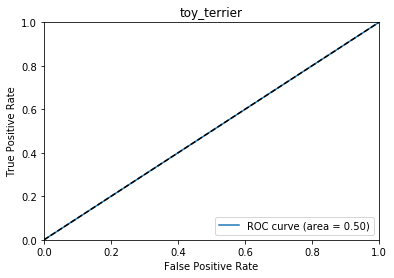

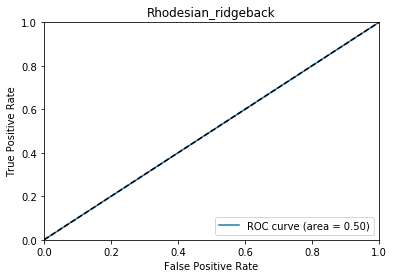

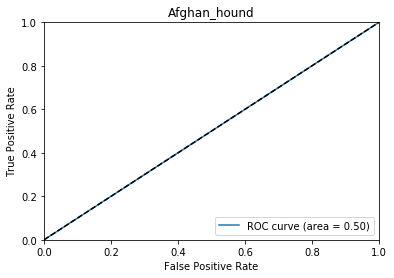

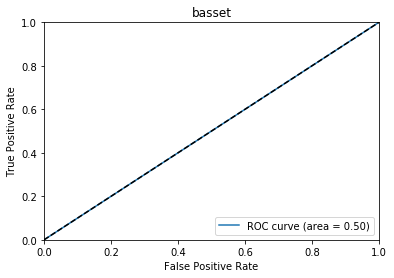

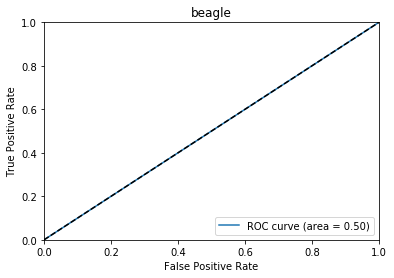

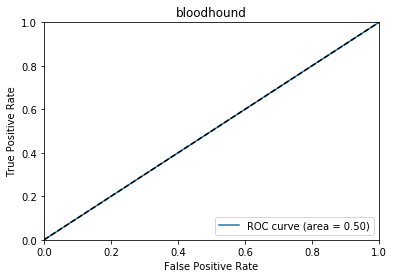

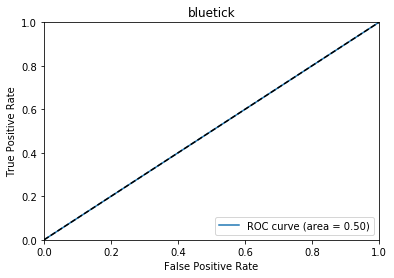

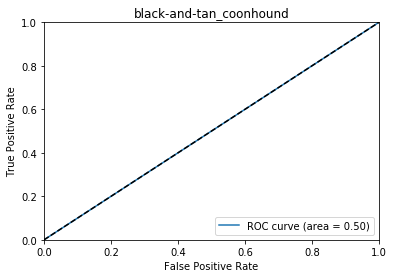

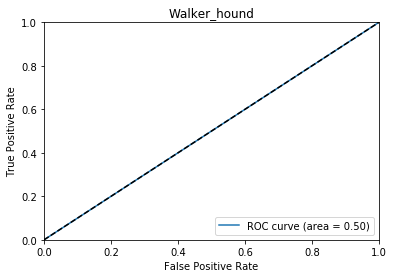

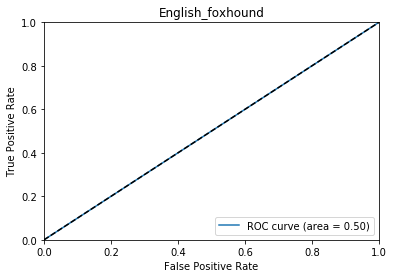

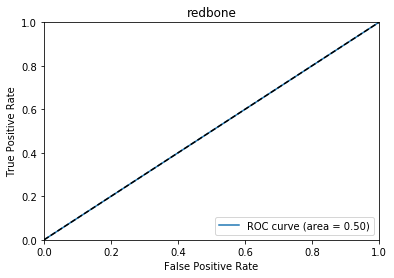

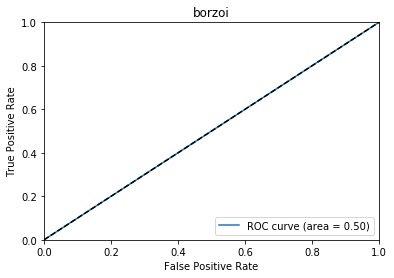

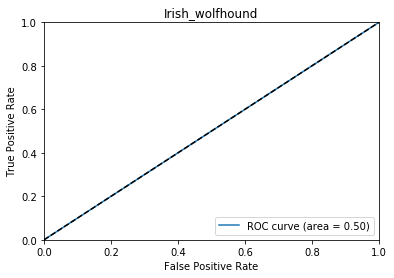

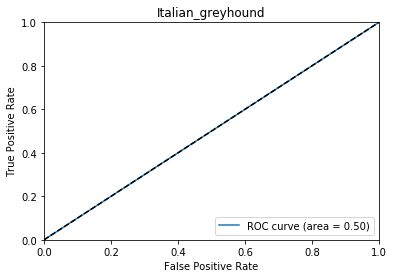

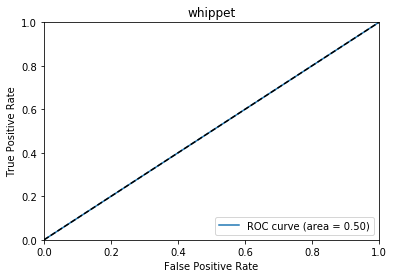

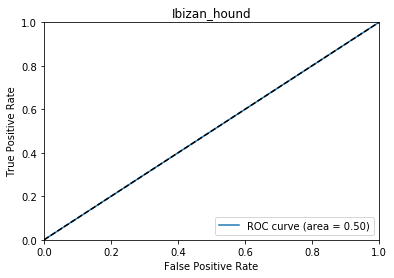

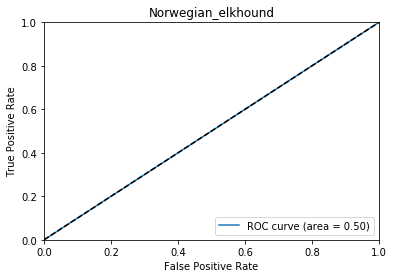

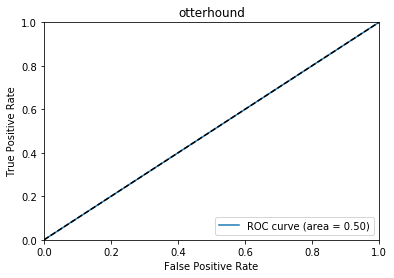

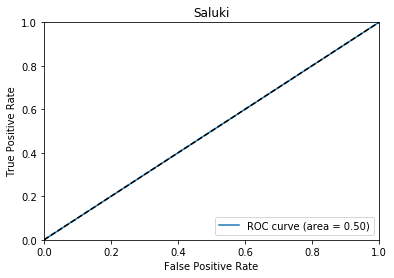

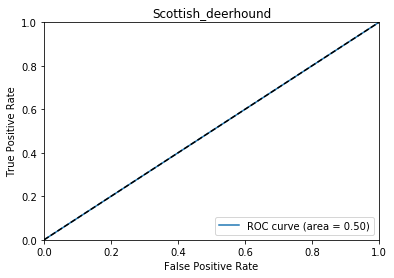

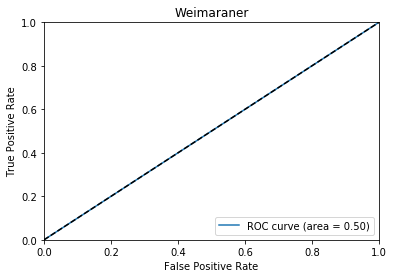

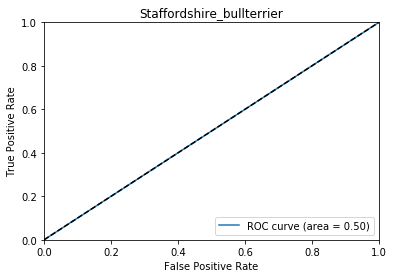

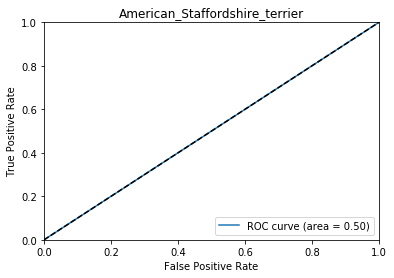

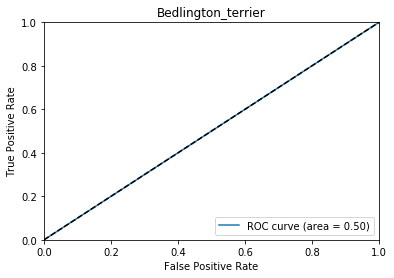

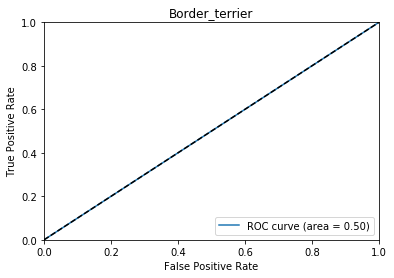

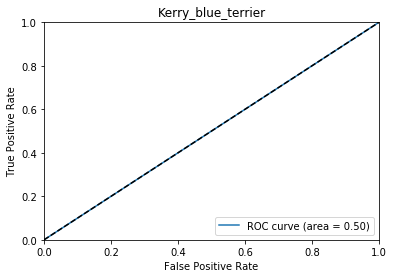

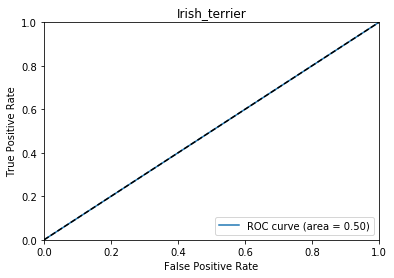

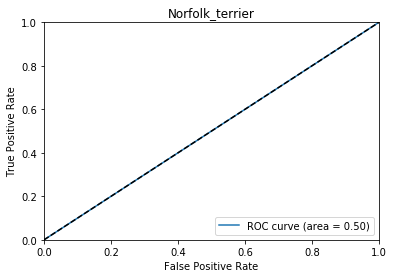

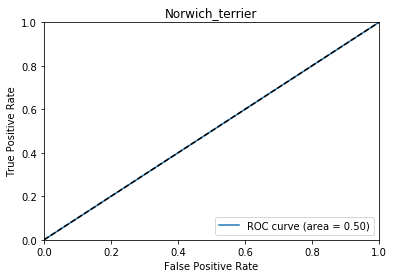

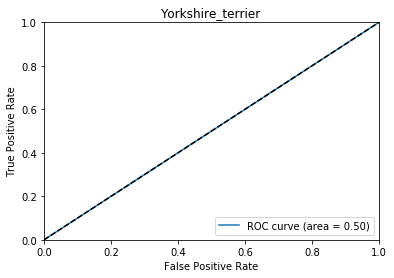

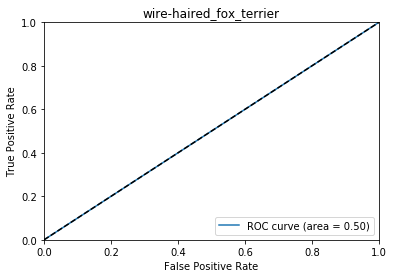

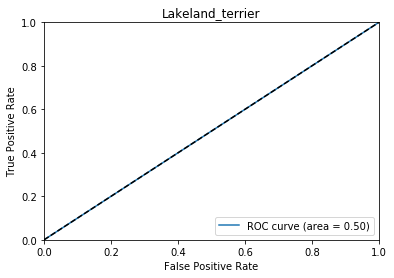

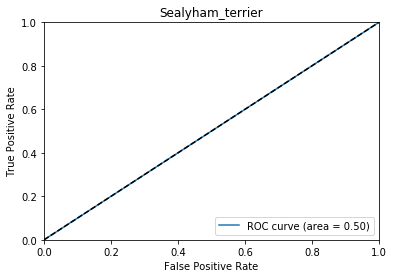

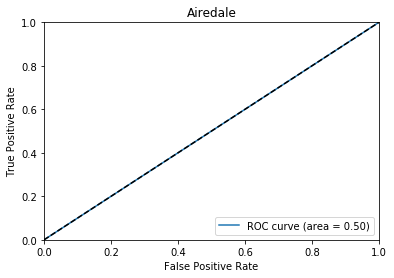

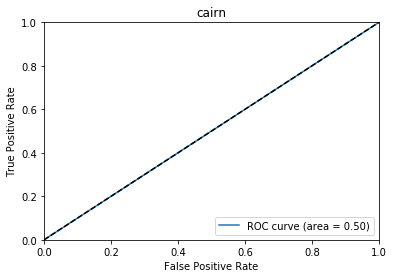

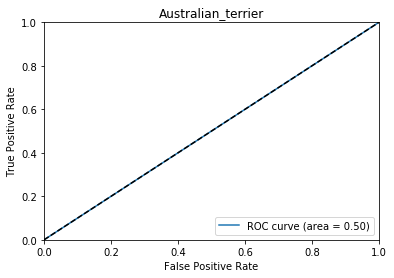

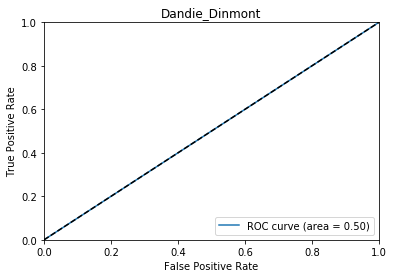

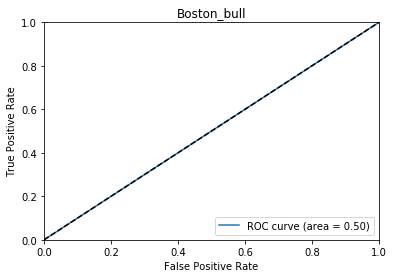

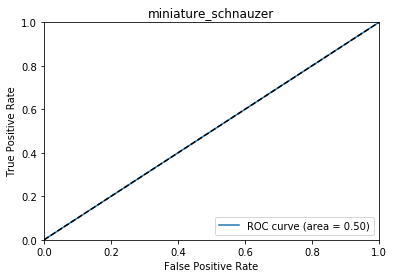

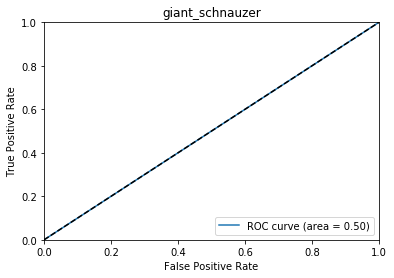

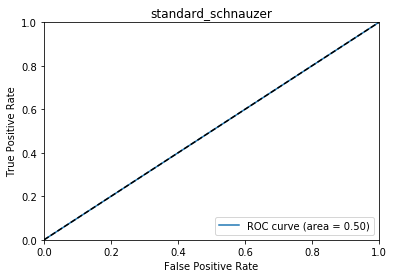

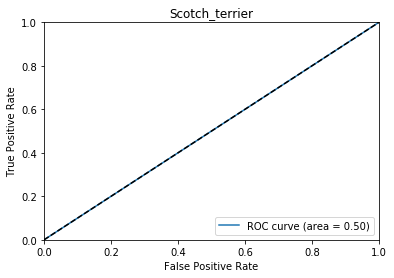

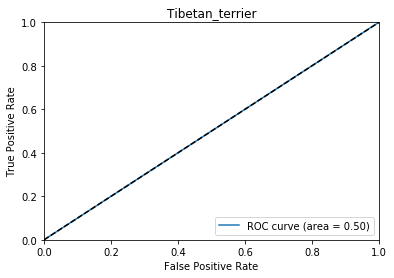

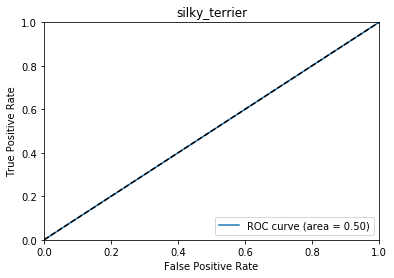

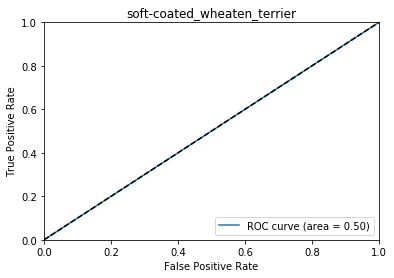

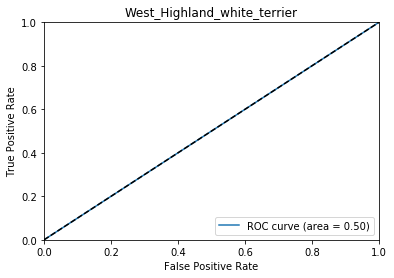

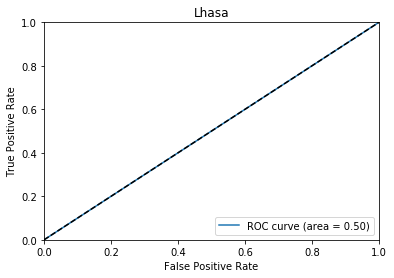

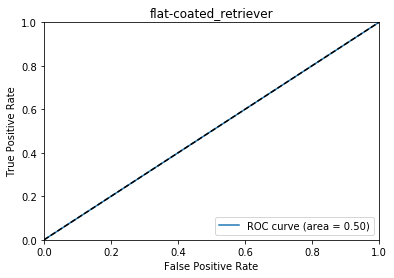

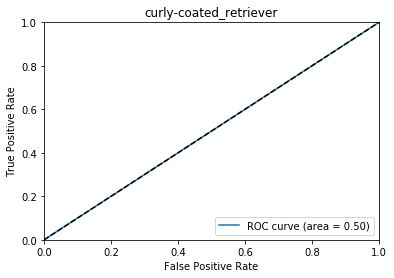

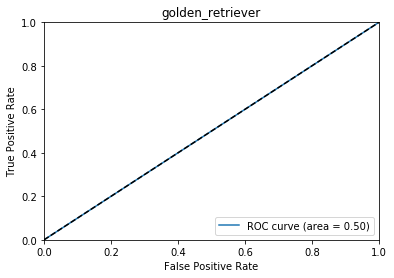

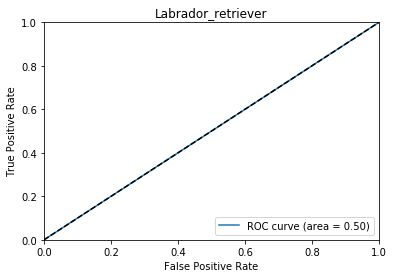

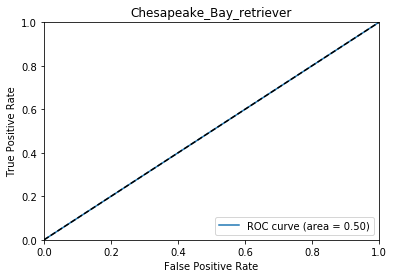

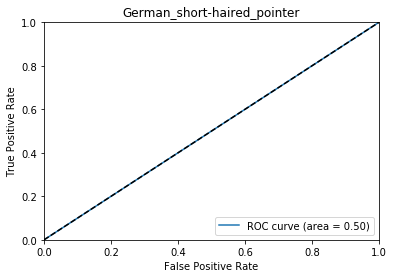

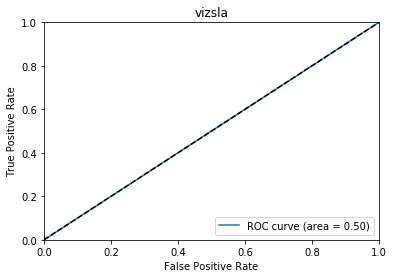

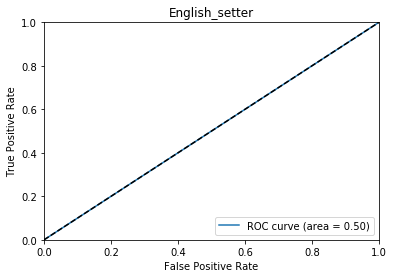

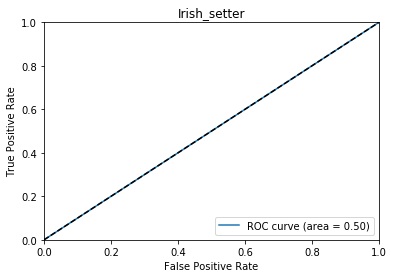

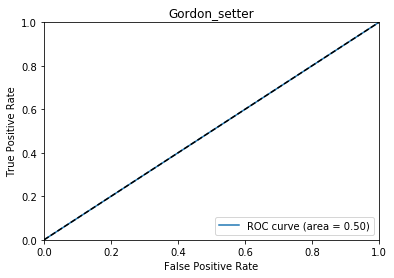

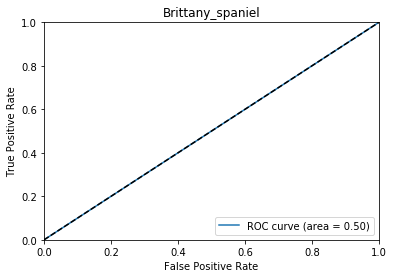

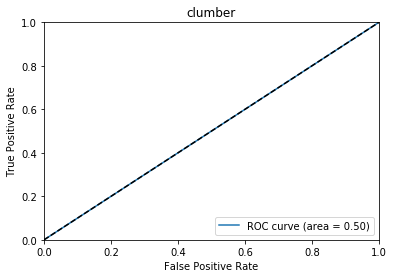

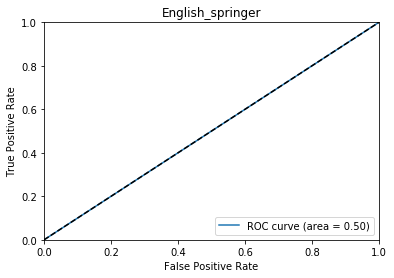

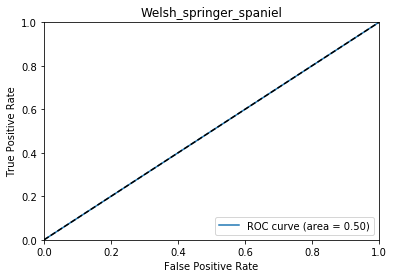

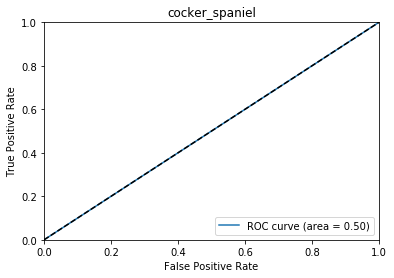

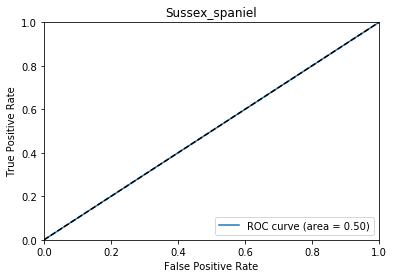

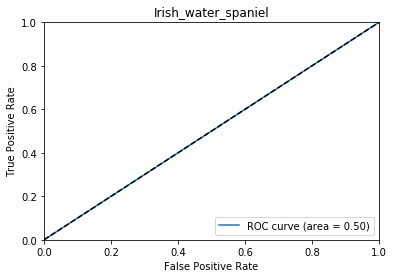

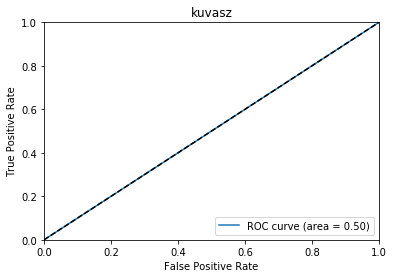

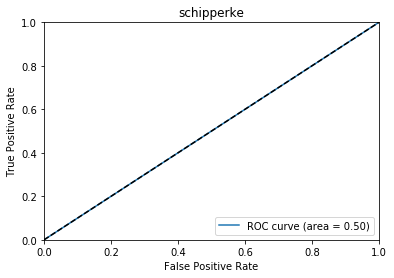

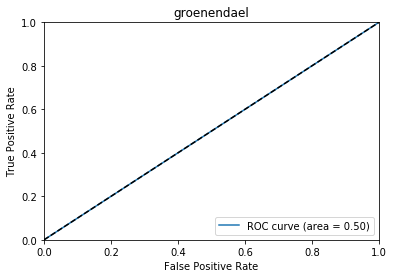

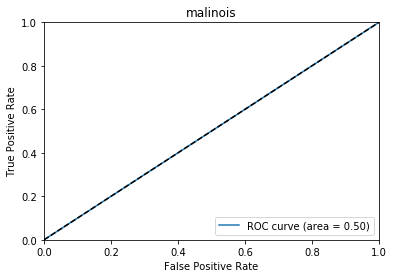

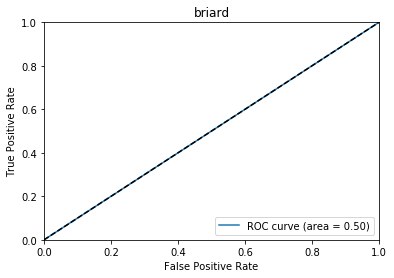

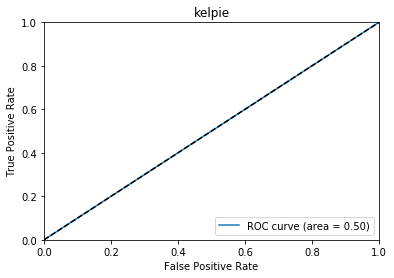

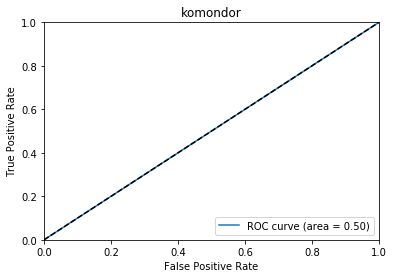

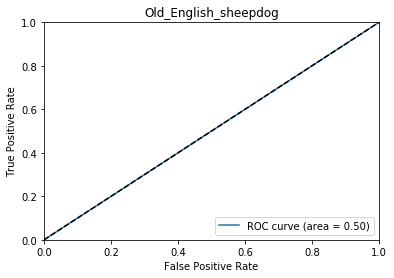

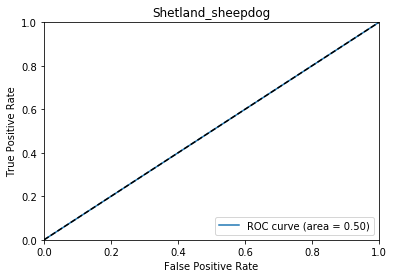

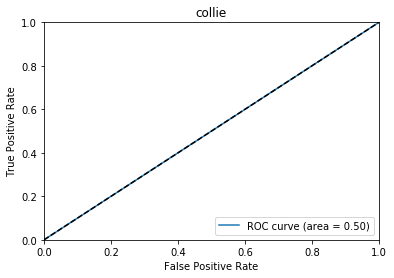

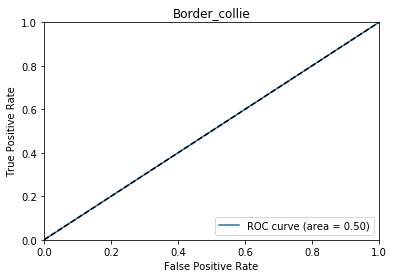

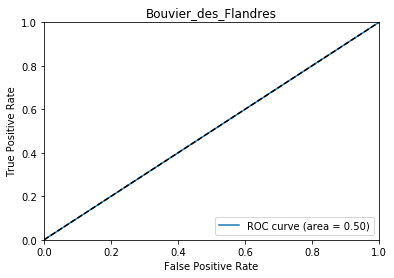

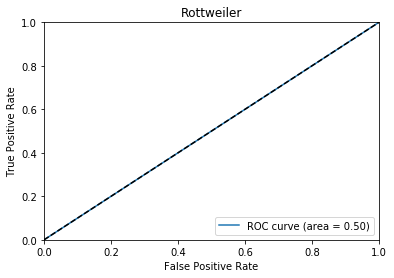

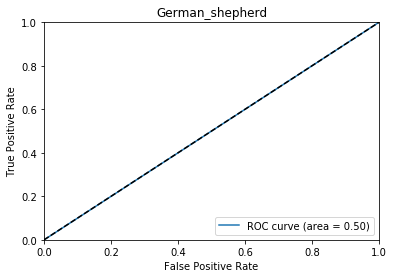

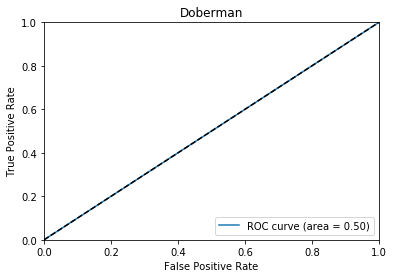

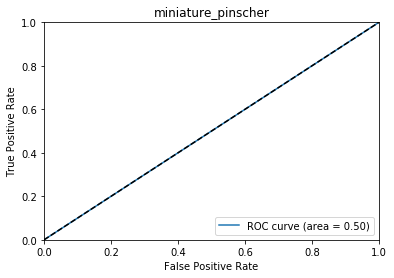

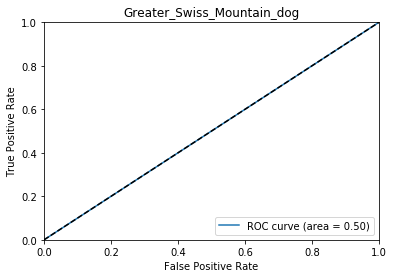

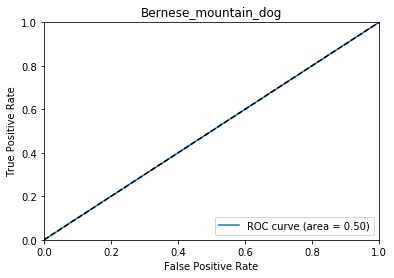

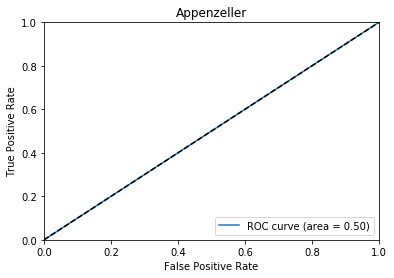

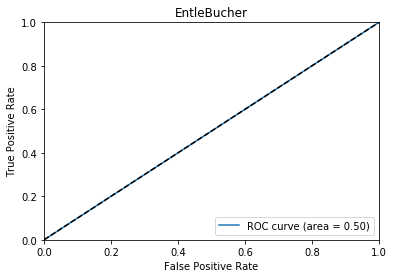

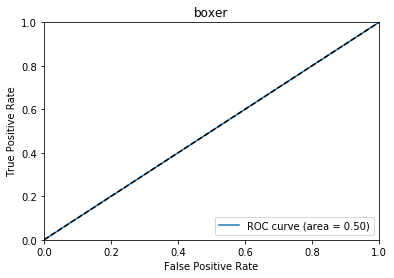

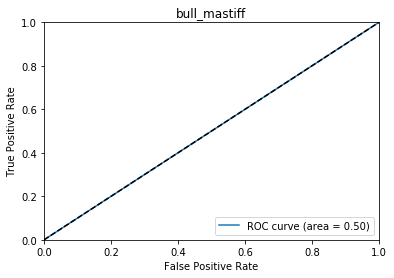

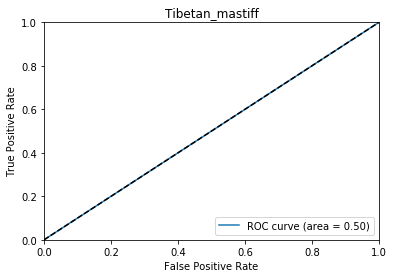

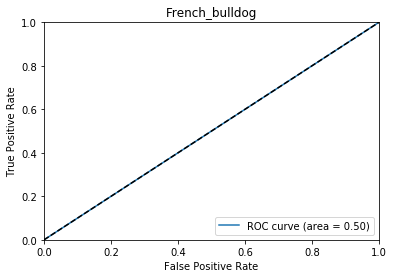

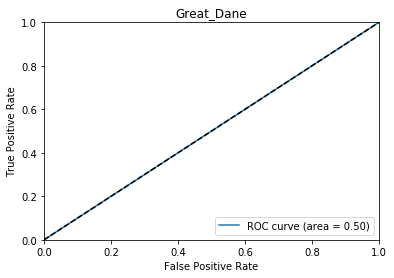

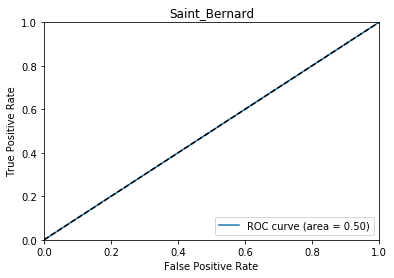

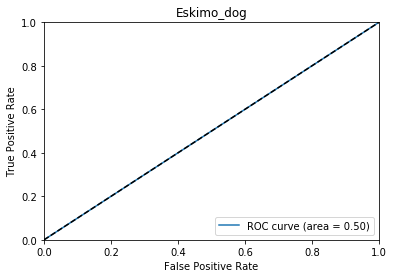

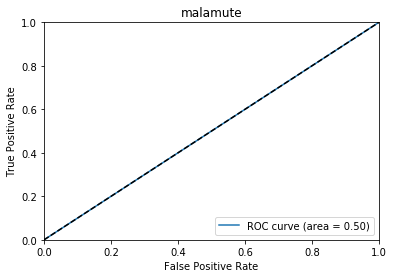

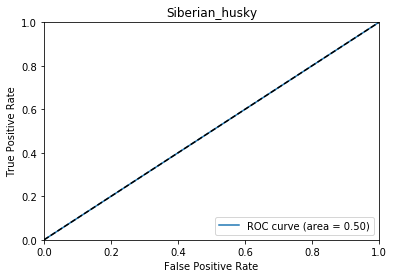

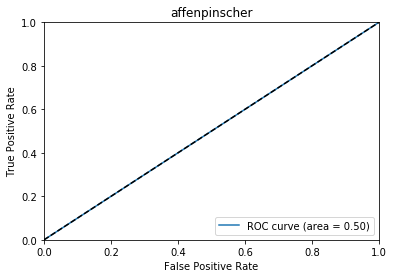

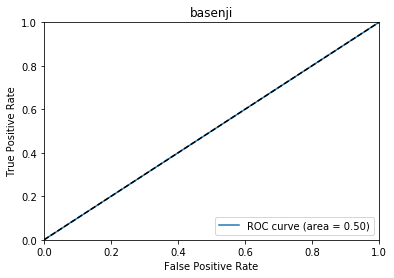

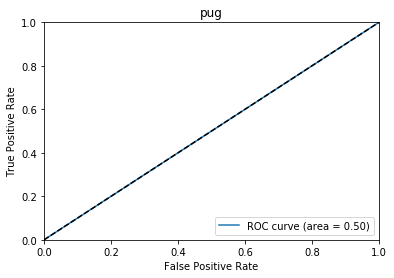

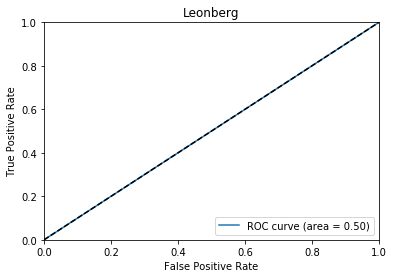

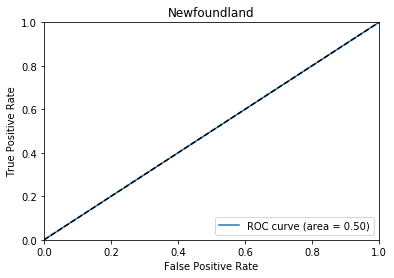

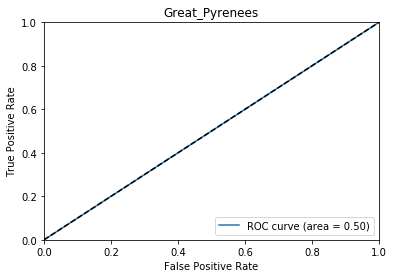

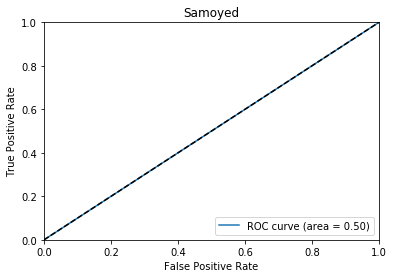

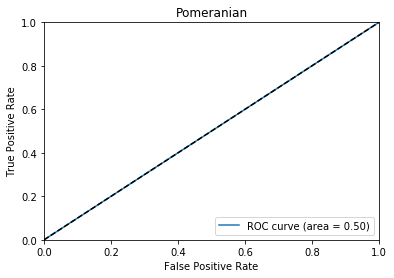

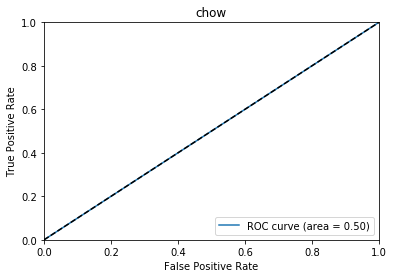

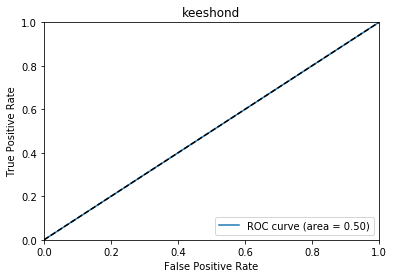

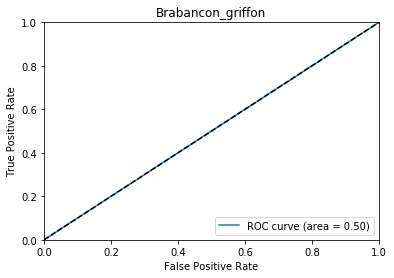

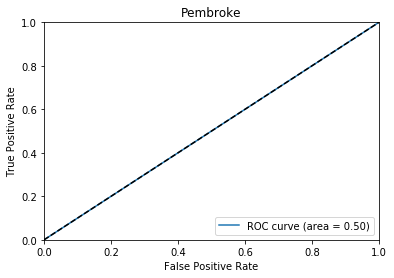

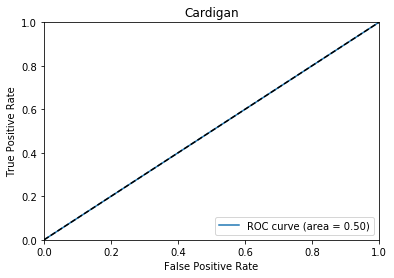

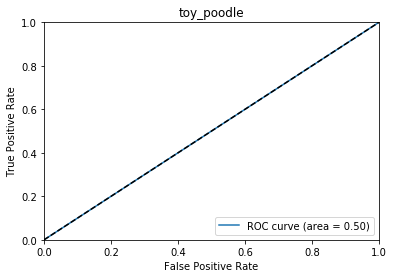

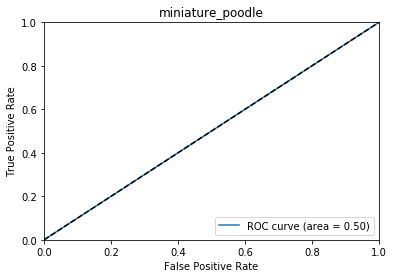

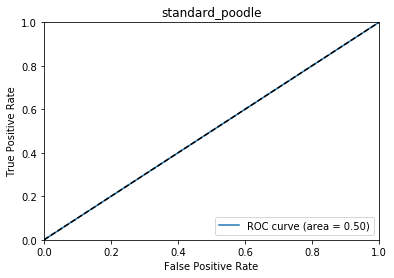

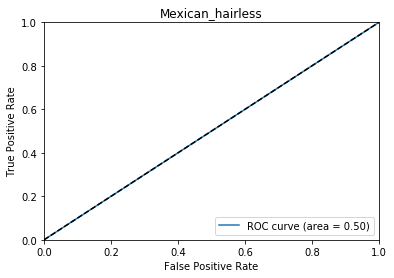

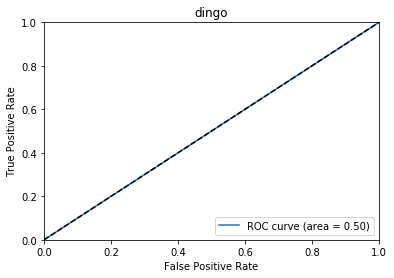

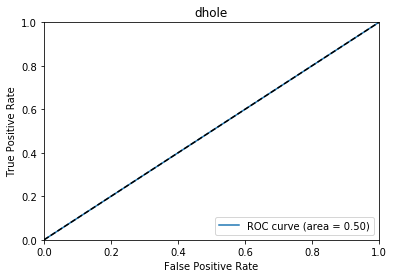

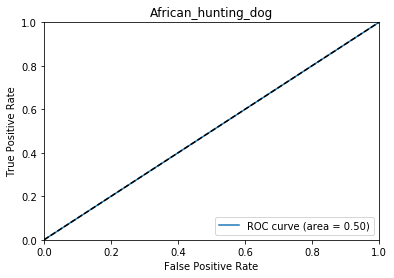

In [46]:
# ROC Curve of original images
plt.figure()
for (i, value) in enumerate(dictionary.values()):
    y_score_index = np.where(mlp_orgn_classes==value)[0][0]
    fpr, tpr, _ = roc_curve(y_test, y_score[y_score_index], pos_label=value)
    roc_auc = auc(fpr, tpr)

    # Plot of a ROC curve for a specific class
    f.add_subplot(60, 2, i+1)
    plt.title(value)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()